# MACHINE LEARNING CAPSTONE PROJECT:  
### TOXIC COMMENT CLASSIFICATION 

1. Import necessary files <br/>
2. Read the train.csv file <br/>
3. List the various fields in our dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df2 = pd.read_csv("labeled_data-Davidson.csv")
df2 = df2.drop(['Unnamed: 0', 'count','hate_speech','offensive_language','neither'], axis=1)

In [ ]:
df2.columns = ['label', 'comment_text']
df2 = df2[['comment_text','label']]
df2

In [ ]:
def f2(row):
    if row['label'] == 1 or row['label'] == 0 :
        val = 1
    else:
        val = 0
    return val

In [ ]:
df2['label'] = df2.apply(f2, axis=1)

In [ ]:
df2

In [2]:
#Read the csv file into dataframe df
df = pd.read_csv("data/jigsaw/train.csv")

In [3]:
def f(row):
    if row['toxic'] == 1 or row['severe_toxic'] == 1 or row['obscene'] == 1 or row['threat'] == 1 or row['insult'] == 1 or row['identity_hate'] == 1:
        val = 1
    else:
        val = 0
    return val


In [4]:
df['label'] = df.apply(f, axis=1)

In [5]:
df = df.drop(['id','toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
df

,comment_text,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [6]:
df.groupby('label').count()

,comment_text
label,
0,143346
1,16225


In [ ]:
df_combine = pd.concat([df,df2], axis=0)

In [ ]:
df_combine

In [ ]:
df_combine.groupby('label').count()

In [ ]:
df3 = df_combine[df_combine['label'] == 0]
df4 = df_combine[df_combine['label'] == 1]


df3 =df3.sample(n=40000)

In [ ]:
df3

In [ ]:
df_combine_final = pd.concat([df3,df4], axis=0)

In [ ]:
df_combine_final.groupby('label').count()

# Separate the comment field data and outcome labels

In [7]:
# comment = df_combine_final['comment_text']
comment = df['comment_text']
print(comment.head())
comment = comment.as_matrix()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object


C:\Users\chenc149\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
# label = df_combine_final[['label']]
label = df[['label']]
print(label.head())
label = label.as_matrix()

   label
0      0
1      0
2      0
3      0
4      0


C:\Users\chenc149\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


## Data Visualisations
### Let us analyse the no. of comments having lengths varying from 0 to 1200

average length of comment: 394.073


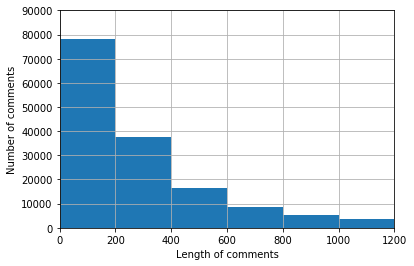

In [9]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

### Number of comments classified as toxic,severe_toxic,....etc depending on their lengths

### Remove excessive length comments
Some very large length comments can be seen, in our dataset. These pose serious problems like adding excessively more words to the training dataset, causing training time to increase and accuracy to decrease!<br/>
Hence, a threshold of 400 characters will be created and only comments which have length smaller than 400 will be used further.

In [10]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [11]:
labels = np.asarray(labels)

In [12]:
print(len(comments))

115910


In [13]:
labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

Hence, after removing comments longer than 400 characters, we are still left with more than 69000 comments, which seems enough for training purposes.

# Preprocessing 
Preprocessing involved the following steps, but these will be performed in a slightly different manner:
- Removing Punctuations and other special characters
- Splitting the comments into individual words
- Removing Stop Words
- Stemming and Lemmatising
- Applying Count Vectoriser
- Splitting dataset into Training and Testing

## Preparing a string containing all punctuations to be removed
The string library contains punctuation characters. This is imported and all numbers are appended to this string. Also, we can notice that our comment_text field contains strings such as won't, didn't, etc which contain apostrophe character('). To prevent these words from being converted to wont/didnt, the character ' represented as \' in escape sequence notation is replaced by empty character in the punctuation string. <br/>

**maketrans()** returns a translation table that maps each character in the punctuation_edit into the character at the same position in the outtab string i.e. it replaces every character in the removal list with a space, since outtab contains a string with spaces.

In [14]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


## Updating the list of stop words
**Stop words** are those words that are frequently used in both written and verbal communication and thereby do not have either a positive/negative impact on our statement.E.g. is, this, us,etc. <br/>
Single letter words if existing or created due to any preprocessing step do not convey any useful meaning and hence can be directly removed. Hence letters from b to z, will be added to the list of stop words imported directly.

In [16]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

In [17]:
print (stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

## Stemming and Lemmatizing
**Stemming** is the process of converting inflected/derived words to their word stem or the root form. Basically, a large number of similar origin words are converted to the same word.E.g. words like "stems", "stemmer", "stemming", "stemmed" as based on "stem". This helps in achieving the training process with a better accuracy.<br/>
**Lemmatizing** is the process of grouping together the inflected forms of a word so they can be analysed as a single item. This is quite similar to stemming in its working but differs since it depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.<br/>
The **wordnet library in nltk** will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.


In [18]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [19]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chenc149\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### We can now, loop once through all the comments applying :
- punctuation removal
- splitting the words by space
- applying stemmer and lemmatizer
- recombining the words again for further processing

In [20]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

## Applying Count Vectorizer
Here we can finally convert our comments into a matrix of token counts, which signifies the number of times it occurs.

In [21]:
#import required library
from sklearn.feature_extraction.text import CountVectorizer

#create object supplying our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments)

In [22]:
# print(count_vector.get_feature_names())
print(tf.shape)

(115910, 72310)


Hence from its shape we can imply that after all preprocessing we have a list of 52905 words in total.
## Splitting dataset into training and testing
- Since the system was going out of memory using train_test_split, I had jumbled all the indexes in the beginning itself. 
- The shuffle function defined here performs the task of assigning first 2/3rd values to train and remaining 1/3rd values to the test set.

In [27]:
labels.shape

(115910, 1)

In [28]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)
print(X_train)

(38636, 72310)
(77274, 72310)
  (0, 49663)	1
  (0, 69480)	1
  (0, 40845)	1
  (0, 62580)	1
  (1, 57244)	1
  (1, 10195)	1
  (1, 2375)	1
  (1, 69451)	1
  (1, 20613)	1
  (1, 46955)	1
  (1, 27807)	1
  (1, 44903)	1
  (1, 26210)	1
  (2, 18977)	1
  (2, 6295)	1
  (2, 63139)	1
  (2, 12734)	1
  (2, 66076)	1
  (2, 10391)	1
  (2, 58563)	1
  (2, 62770)	2
  (2, 38569)	1
  (2, 58626)	1
  (2, 60474)	1
  (2, 21596)	1
  :	:
  (77271, 564)	1
  (77272, 58632)	1
  (77272, 67039)	1
  (77272, 22080)	1
  (77272, 15642)	1
  (77272, 50117)	1
  (77272, 36676)	2
  (77272, 36033)	1
  (77272, 564)	1
  (77272, 43884)	1
  (77273, 52594)	1
  (77273, 4724)	2
  (77273, 29371)	2
  (77273, 12521)	1
  (77273, 33857)	1
  (77273, 65378)	1
  (77273, 52826)	1
  (77273, 27491)	1
  (77273, 24979)	2
  (77273, 5025)	2
  (77273, 62620)	1
  (77273, 12403)	1
  (77273, 30584)	1
  (77273, 51320)	1
  (77273, 17448)	1


# Implementation :
### Let us define all the evaluation metrics

In [29]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))

## Starting with the First Model -
### Problem Transformation Methods :
**These include the Binary Relevance, Label Powerset and Classifier Chain methods. Implementations of these methods is available in the scikit-multilearn library. **
- I will be implementing the most basic method,which is the **Binary Relevance** method from scratch. It does not take into account the interdependence of labels and basically creates a separate classifier for each of the labels.
- Scikit-multilearn library's classifier will also be imported and tested with different classifiers to observe if it gives similar results.

### 1. Binary Relevance (BR) Method with MultinomialNB classifiers (from scratch)

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
# clf will be the list of the classifiers for all the 6 labels
# each classifier is fit with the training data and corresponding classifier
clf = []
for ix in range(1):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [32]:
# predict list contains the predictions, it is transposed later to get the proper shape
predict = []
for ix in range(1):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(38636, 1)


In [33]:
# 沒有加入dataset
evaluate_score(Y_test,predict)

Hamming_loss : 6.525002588259654
Accuracy : 93.47499741174035


In [ ]:
# 加dataset
evaluate_score(Y_test,predict)

In [ ]:
# 調整成兩個label數字差不多
evaluate_score(Y_test,predict)

In [35]:
type(X_train)

scipy.sparse.csr.csr_matrix